In [1]:
# let's handle imports first.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import networkx as nx
import scipy.stats

warnings.filterwarnings("ignore")

# Automated formatter.
import jupyter_black

jupyter_black.load()

# Introduction
Welcome to my Music League analysis! I decided to do this for fun because I thought the dataset was rich and it would be interesting to see the music preferences and relationships from within our group. I also found the final analytics insight from the app a little lackluster so I thought people would want to see a more in-depth view of player behaviors.

Disclaimer: Analyses here are for-funsies only, and not subject to academic levels of rigor. 

# Methodology
I built a [scraper](https://github.com/wmau/music_league/blob/main/scraper/scraper.py) that trawled the Music League web app for all the submission and voting data in every league that I participated in. Funnily enough, a week after I finished the scraper, Music League started advertising their subscriber feature for [data exports](https://www.reddit.com/r/musicleague/comments/1e2idmt/now_available_to_music_league_subscribers_league/) but don't let them know about me! 

I also leveraged the [Spotify API](https://developer.spotify.com/documentation/web-api) to acquire external data about individual songs. Using [spotipy](https://spotipy.readthedocs.io/en/2.24.0/), I made calls to find:
1. The artist's "popularity". Spotify's [documentation](https://developer.spotify.com/documentation/web-api/reference/get-an-artist) is not very thorough about the specifics of how this metric was calculated, but seems to suggest that it's an aggregate of the play count of all the artist's tracks, weighted by the recency of the plays and ranges from 0-100.
2. The artist's genres.
3. The song's "popularity".
4. And the [audio features](https://developer.spotify.com/documentation/web-api/reference/get-several-audio-features) of each song.

## Read data

In [2]:
submissions = pd.read_csv("../data/round_submissions.csv").query(
    "league_title == 'Cohere Data League 2024Q2'"
)
rounds = pd.read_csv("../data/rounds.csv").query(
    "league_title == 'Cohere Data League 2024Q2'"
)
results = pd.read_csv("../data/round_results.csv").query(
    "league_title == 'Cohere Data League 2024Q2'"
)

# Join the results to submissions to get Spotify's popularity and genre data.
results = results.merge(
    submissions.drop(columns=["song_name"]),
    how="left",
    on=["round_number", "submitter_name", "league_title"],
)

### Round data
Simply the round number and round name. 

In [3]:
rounds

,league_title,round_name,round_description,round_number
0,Cohere Data League 2024Q2,Earth Day Hits,Songs you love to listen to while embracing th...,1
1,Cohere Data League 2024Q2,British Invasion,Songs by artists from across the pond (the U.K...,2
2,Cohere Data League 2024Q2,Cross Functional Teams,Songs featuring a second artist,3
3,Cohere Data League 2024Q2,Marathons,Songs that are longer than 5 minutes,4
4,Cohere Data League 2024Q2,Lost in Translation,Songs not sung in English,5
5,Cohere Data League 2024Q2,Road Trip Favorites,Songs best listened to on the open road,6
6,Cohere Data League 2024Q2,Music League Go-Live,Songs that were recorded live (insert Bill O'R...,7
7,Cohere Data League 2024Q2,Not an LP,Songs that didn't debut on an LP. EPs and sing...,8
8,Cohere Data League 2024Q2,Movie Soundtrack,Songs made famous by an appearance in a movie,9
9,Cohere Data League 2024Q2,Summer,Songs that make you think of summer,10


### Submission data
Data on the submitting players and their songs, plus data augmented by the Spotify API -- artist popularity and genres. 

In [4]:
submissions

,league_title,round_number,submitter_name,song_name,song_artist,song_album,spotify_link,rank,submitter_comment,voted,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_href,duration_ms,time_signature
0,Cohere Data League 2024Q2,1,Zoe Liao,Alaska,Maggie Rogers,Heard It In A Past Life,https://open.spotify.com/track/4HfLQJtVT1KiX1e...,1,the story behind how this song got popular is ...,True,...,0,0.0507,0.4110,0.001760,0.1080,0.178,104.001,https://api.spotify.com/v1/tracks/4HfLQJtVT1Ki...,188000,4
1,Cohere Data League 2024Q2,1,Parth Jawale,Don't Go Near The Water,Johnny Cash,Ragged Old Flag,https://open.spotify.com/track/4lDLdpmmbx7zns6...,2,NaN,True,...,1,0.0323,0.8700,0.000000,0.2500,0.719,97.136,https://api.spotify.com/v1/tracks/4lDLdpmmbx7z...,170560,4
2,Cohere Data League 2024Q2,1,William Mau,Stick Season,Noah Kahan,Stick Season,https://open.spotify.com/track/0mflMxspEfB0VbI...,3,NaN,True,...,1,0.0651,0.7990,0.000000,0.0966,0.801,117.896,https://api.spotify.com/v1/tracks/0mflMxspEfB0...,182347,4
3,Cohere Data League 2024Q2,1,Tommy Pitcher,Dawn in the Adan,Ichiko Aoba,Windswept Adan,https://open.spotify.com/track/03fJjiNTn1gyzbq...,4,This is my go to album when I go for walks alo...,True,...,0,0.0339,0.9590,0.543000,0.1200,0.199,109.981,https://api.spotify.com/v1/tracks/03fJjiNTn1gy...,285501,4
4,Cohere Data League 2024Q2,1,Ben Barone,Annie's Song,John Denver,Back Home Again,https://open.spotify.com/track/4J0DbyODwZJcmIA...,4,My wife walked down the aisle to this song!,True,...,1,0.0298,0.8710,0.003680,0.3670,0.464,146.066,https://api.spotify.com/v1/tracks/4J0DbyODwZJc...,180693,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Cohere Data League 2024Q2,10,Harsh Bhatt,The Boys Of Summer,Don Henley,Building The Perfect Beast,https://open.spotify.com/track/4gvea7UlDkAvsJB...,3,NaN,True,...,1,0.0373,0.5010,0.005720,0.1840,0.907,176.941,https://api.spotify.com/v1/tracks/4gvea7UlDkAv...,288733,4
76,Cohere Data League 2024Q2,10,William Mau,Every Summertime,NIKI,Every Summertime,https://open.spotify.com/track/68HocO7fx9z0MgD...,4,NaN,True,...,1,0.0424,0.3930,0.000069,0.0978,0.723,78.996,https://api.spotify.com/v1/tracks/68HocO7fx9z0...,215687,4
77,Cohere Data League 2024Q2,10,Jackson Mostoller,Bossa Nova Baby,Teddi Gold,Bossa Nova Baby,https://open.spotify.com/track/16taCB30HVklj9w...,5,NaN,True,...,1,0.0448,0.1530,0.000136,0.1490,0.940,150.074,https://api.spotify.com/v1/tracks/16taCB30HVkl...,153373,4
78,Cohere Data League 2024Q2,10,Parth Jawale,This Must Be the Place (Naive Melody) - 2005 R...,Talking Heads,Speaking in Tongues (Deluxe Version),https://open.spotify.com/track/6aBUnkXuCEQQHAl...,6,NaN,True,...,1,0.0333,0.3310,0.179000,0.0280,0.966,114.443,https://api.spotify.com/v1/tracks/6aBUnkXuCEQQ...,296147,4


### Voting data
How everyone voted each round.

In [5]:
results

,league_title,round_number,submitter_name,song_name,voter_name,vote_value,voter_comment,song_artist,song_album,spotify_link,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_href,duration_ms,time_signature
0,Cohere Data League 2024Q2,1,Zoe Liao,Alaska,Parth Jawale,2,NaN,Maggie Rogers,Heard It In A Past Life,https://open.spotify.com/track/4HfLQJtVT1KiX1e...,...,0,0.0507,0.4110,0.00176,0.108,0.178,104.001,https://api.spotify.com/v1/tracks/4HfLQJtVT1Ki...,188000,4
1,Cohere Data League 2024Q2,1,Zoe Liao,Alaska,Jackson Mostoller,2,NaN,Maggie Rogers,Heard It In A Past Life,https://open.spotify.com/track/4HfLQJtVT1KiX1e...,...,0,0.0507,0.4110,0.00176,0.108,0.178,104.001,https://api.spotify.com/v1/tracks/4HfLQJtVT1Ki...,188000,4
2,Cohere Data League 2024Q2,1,Zoe Liao,Alaska,Emma Nien,2,NaN,Maggie Rogers,Heard It In A Past Life,https://open.spotify.com/track/4HfLQJtVT1KiX1e...,...,0,0.0507,0.4110,0.00176,0.108,0.178,104.001,https://api.spotify.com/v1/tracks/4HfLQJtVT1Ki...,188000,4
3,Cohere Data League 2024Q2,1,Zoe Liao,Alaska,Roger Qiu,1,NaN,Maggie Rogers,Heard It In A Past Life,https://open.spotify.com/track/4HfLQJtVT1KiX1e...,...,0,0.0507,0.4110,0.00176,0.108,0.178,104.001,https://api.spotify.com/v1/tracks/4HfLQJtVT1Ki...,188000,4
4,Cohere Data League 2024Q2,1,Zoe Liao,Alaska,Ben Barone,1,NaN,Maggie Rogers,Heard It In A Past Life,https://open.spotify.com/track/4HfLQJtVT1KiX1e...,...,0,0.0507,0.4110,0.00176,0.108,0.178,104.001,https://api.spotify.com/v1/tracks/4HfLQJtVT1Ki...,188000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,Cohere Data League 2024Q2,10,Parth Jawale,This Must Be the Place (Naive Melody) - 2005 R...,Tommy Pitcher,1,NaN,Talking Heads,Speaking in Tongues (Deluxe Version),https://open.spotify.com/track/6aBUnkXuCEQQHAl...,...,1,0.0333,0.3310,0.17900,0.028,0.966,114.443,https://api.spotify.com/v1/tracks/6aBUnkXuCEQQ...,296147,4
372,Cohere Data League 2024Q2,10,Parth Jawale,This Must Be the Place (Naive Melody) - 2005 R...,William Mau,0,Not summery for me,Talking Heads,Speaking in Tongues (Deluxe Version),https://open.spotify.com/track/6aBUnkXuCEQQHAl...,...,1,0.0333,0.3310,0.17900,0.028,0.966,114.443,https://api.spotify.com/v1/tracks/6aBUnkXuCEQQ...,296147,4
373,Cohere Data League 2024Q2,10,Tommy Pitcher,Sunny Summer,Roger Qiu,1,NaN,GFRIEND,GFRIEND Summer Mini Album 'Sunny Summer',https://open.spotify.com/track/7IE8eERSpTC9Jaw...,...,1,0.0862,0.0491,0.00000,0.313,0.880,129.984,https://api.spotify.com/v1/tracks/7IE8eERSpTC9...,198536,4
374,Cohere Data League 2024Q2,10,Tommy Pitcher,Sunny Summer,Zoe Liao,1,NaN,GFRIEND,GFRIEND Summer Mini Album 'Sunny Summer',https://open.spotify.com/track/7IE8eERSpTC9Jaw...,...,1,0.0862,0.0491,0.00000,0.313,0.880,129.984,https://api.spotify.com/v1/tracks/7IE8eERSpTC9...,198536,4


# Results

## Part I. Player and song performance
### Points every round
This shows your progress over each round. Not many exciting insights here other than how dominant Will was throughout the quarter :)

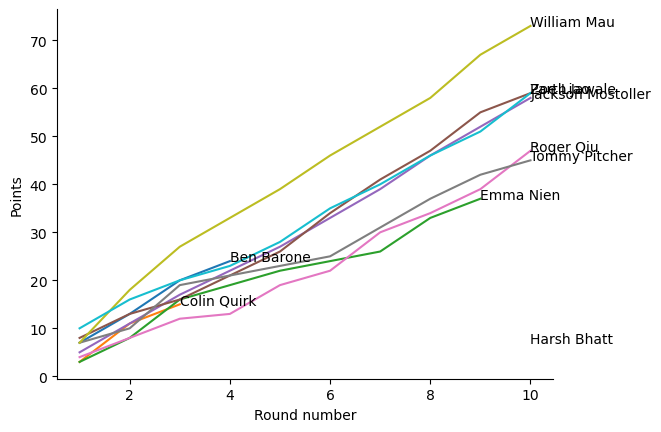

In [10]:
points = (
    results.query("voted | (~voted & vote_value < 0)")
    .groupby(["submitter_name", "round_number"])["vote_value"]
    .sum()
    .groupby(level=0)
    .cumsum()
    .reset_index()
    .rename(columns={"vote_value": "points"})
)
final_score = points.groupby("submitter_name").last()

fig, ax = plt.subplots()

sns.lineplot(
    data=points, x="round_number", y="points", hue="submitter_name", legend=False, ax=ax
)

for i, player in final_score.iterrows():
    ax.annotate(player.name, (player["round_number"], player["points"]))
[ax.spines[side].set_visible(False) for side in ["top", "right"]]
ax.set_xlabel("Round number")
_ = ax.set_ylabel("Points")

### Number of podium finishes
This plot shows the number of top 3 finishes each round. 
- **Will** was the most decorated player, with five 1st places, one 2nd, and two 3rd.
- **Jackson** and **Parth** tied in podium finishes with 5 each, though Parth had three 2nd place finishes while Jackson had three 3rd place finishes.

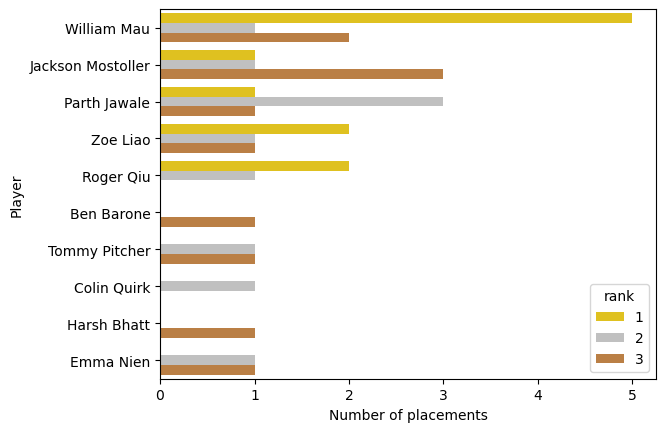

In [12]:
podium_finishes = (
    submissions.groupby(["submitter_name", "rank"])["round_number"]
    .count()
    .reset_index()
    .rename(columns={"round_number": "placements"})
    .query("rank <= 3")
    .sort_values("placements", ascending=False)
)

colors = ["#FFD700", "#C0C0C0", "#CD7F32"]
podium_palette = sns.color_palette(colors)

fig, ax = plt.subplots()

sns.barplot(
    data=podium_finishes,
    y="submitter_name",
    x="placements",
    hue="rank",
    palette=podium_palette,
    ax=ax,
)
ax.set_xlabel("Number of placements")
_ = ax.set_ylabel("Player")

### Song performances
I always enjoyed Spotify Wrapped. Here's kind of the Music League version. How did each song do individually? Below, let's aggregate the vote totals for each song and sort them.

In [13]:
# Aggregate by song.
song_totals = (
    results.query("vote_value != 0")
    .groupby(["round_number", "submitter_name", "song_name"])
    .agg(
        vote_value=("vote_value", "sum"),
        upvote_total=("vote_value", lambda x: x[x > 0].sum()),
        downvote_total=("vote_value", lambda x: x[x < 0].sum()),
    )
    .sort_values("vote_value", ascending=False)
    .reset_index()
)

song_totals["song_and_submitter"] = (
    song_totals["submitter_name"] + ": " + song_totals["song_name"]
)

## Top 10 songs
These were the best performing songs for this quarter. 
- **Will's** songs had 3 appearances in the top 10, which is not surprising given his 1st place finish.
- **Tommy's** songs appear on this list twice despite only coming in 6th suggesting he had some banger rounds but could improve on round-to-round consistency.
- Surprisingly, **Parth's** songs only show up in this list once and **Jackson's** not at all, suggesting they are Tommy's foils -- that they are fairly consistent across rounds but lacked rounds with smash hits. 

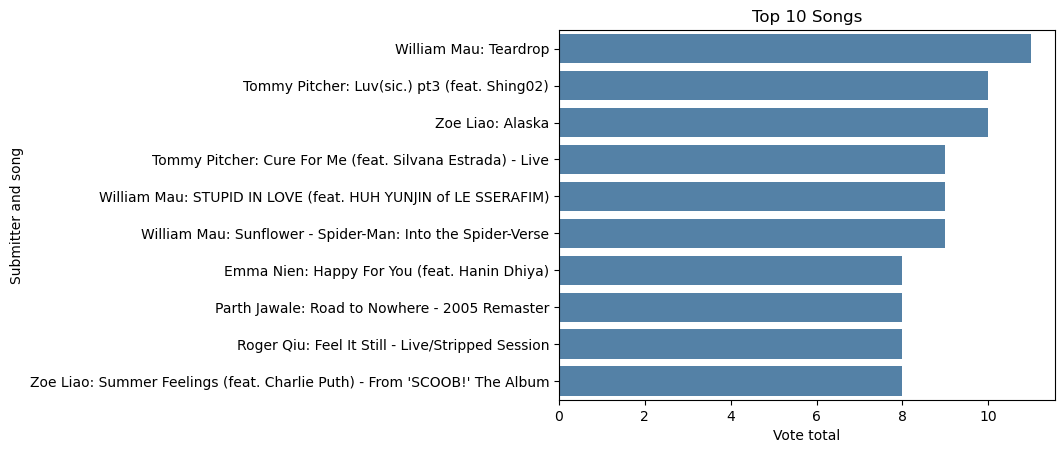

In [14]:
fig, ax = plt.subplots()

sns.barplot(
    data=song_totals.iloc[:10],
    x="vote_value",
    y="song_and_submitter",
    color="steelblue",
    ax=ax,
)
ax.set_title("Top 10 Songs")
ax.set_xlabel("Vote total")
_ = ax.set_ylabel("Submitter and song")

### Bottom 10 songs
Here are the worst performing songs of the quarter. 
- Three appearances by **Emma** shows these picks are not very popular with the crowd unfortunately :(
- Two appearances by **Tommy** is consistent with the assessment above. 

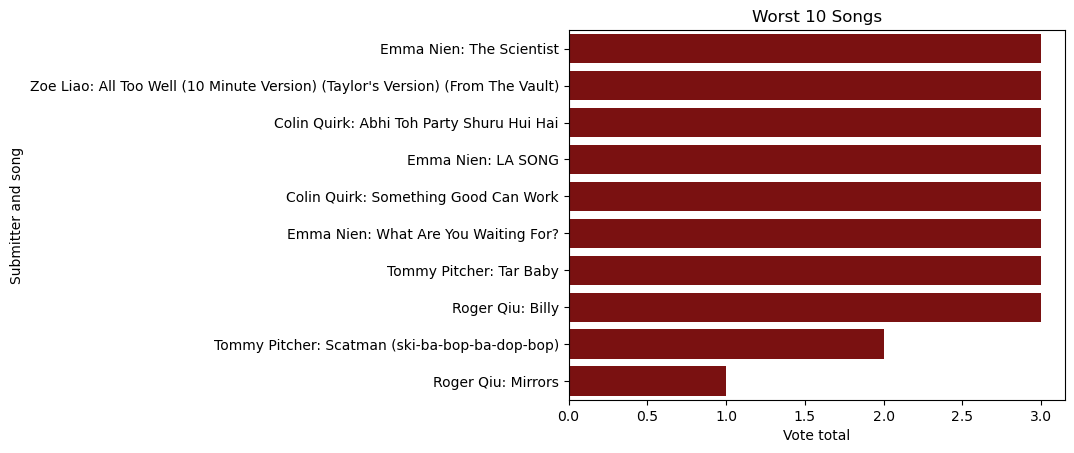

In [15]:
fig, ax = plt.subplots()

sns.barplot(
    data=song_totals.iloc[-10:],
    x="vote_value",
    y="song_and_submitter",
    color="darkred",
    ax=ax,
)
ax.set_title("Worst 10 Songs")
ax.set_xlabel("Vote total")
_ = ax.set_ylabel("Submitter and song")

## Part II. Artist & song popularity
I love Music League because it exposes me to amazing artists I've never listened to. My objective for every round has been to share music that I enjoy and others may not have heard before. So personally, I was interested in who was submitting the most indie versus the most basic songs. Luckily for us, Spotify quantifies popularity of both the artist and the song itself, though the methodology for how these are computed is not formally defined:

For song popularity:
> The popularity of the track. The value will be between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.
Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity. Note: the popularity value may lag actual popularity by a few days: the value is not updated in real time.

For artist popularity:
>The popularity of the artist. The value will be between 0 and 100, with 100 being the most popular. The artist's popularity is calculated from the popularity of all the artist's tracks.

First, I wanted to verify the [face validity](https://en.wikipedia.org/wiki/Face_validity) of Spotify's popularity metrics:
- The distribution of artist popularity seems to be more or less normal with a left tail (lower popularity scores). In contrast, song popularities appear to follow a somewhat bimodal distribution. This suggests that while most players are listening to popular artists (and to some indie artists, as demonstrated by the left tail), some players are also listening to some less popular songs.
- Artist popularity takes a notable dip in round 5 (Lost in Translation), which is consistent with the idea that non-English artists are less popular on Spotify in general.
- Interestingly, this dip is not as apparent in at the track level, suggesting that maybe our selected non-English songs are more on the popular side as far as non-English songs go. 

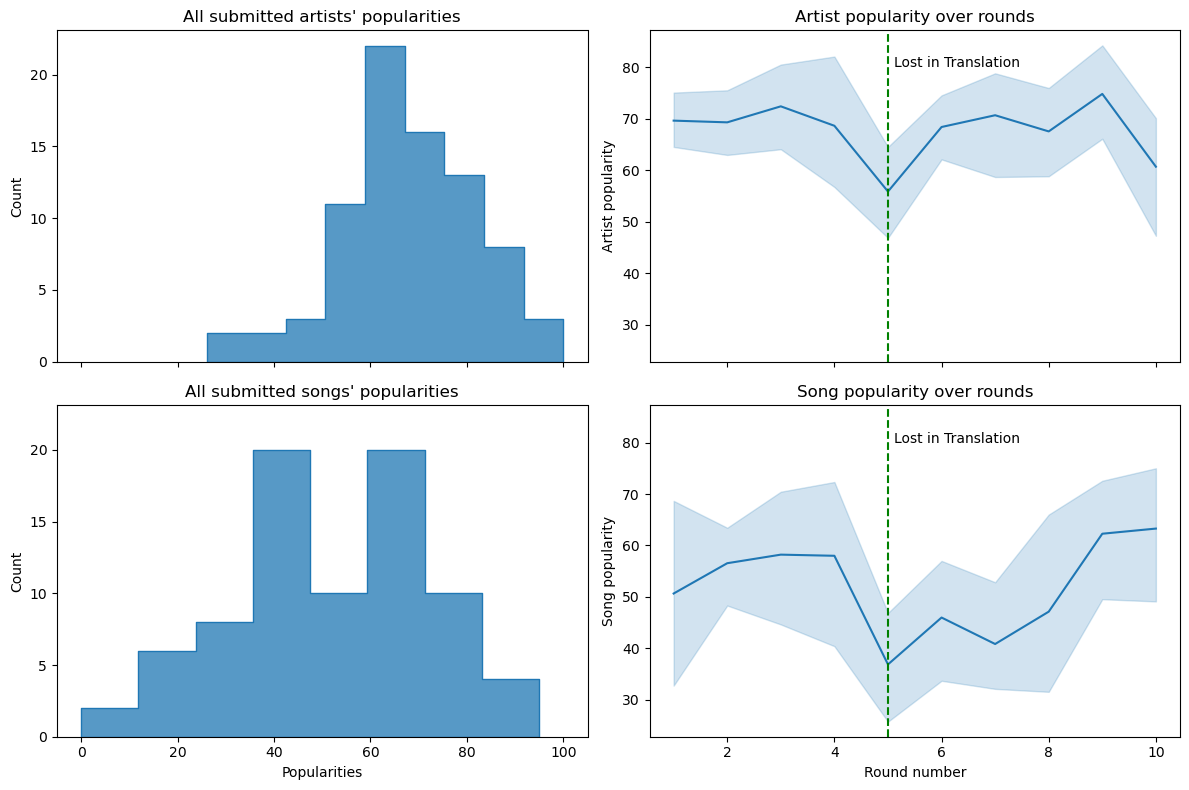

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex="col", sharey="col")

for ax_row, col in zip(axs, ["artist_popularity", "song_popularity"]):
    pretty_col = col.capitalize().replace("_", " ")
    sns.histplot(data=submissions, x=col, element="step", ax=ax_row[0])
    ax_row[0].set_xlabel("Popularities")
    ax_row[0].set_title(f"All submitted {col.split("_")[0]}s' popularities")

    sns.lineplot(data=submissions, x="round_number", y=col, ax=ax_row[1])
    for round_number in [5]:
        ax_row[1].axvline(x=round_number, color="green", linestyle="--")
        ax_row[1].annotate(
            rounds.query("round_number == @round_number")["round_name"].values[0],
            xy=(round_number, 80),
            xytext=(4, 0),
            textcoords="offset points",
        )

    ax_row[1].set_xlabel("Round number")
    ax_row[1].set_ylabel(pretty_col)
    _ = ax_row[1].set_title(f"{pretty_col} over rounds")

fig.tight_layout()

Because each track has both a popularity metric for the artist and the track itself, we can compare the two in the same submission. The plot below shows the same track's **song popularity** compared to its **artist popularity**. Songs below the identity line are what you can call "deep cuts" (i.e., lesser known songs) because its song popularity is less than its artist popularity. Notably, **Jackson** and **Emma** have a large concentration of submissions in this area, suggesting that they don't simply listen to the most popular songs of a popular artist, but also their lesser-known tracks.

(-5.0, 105.0, -4.75, 105.25)

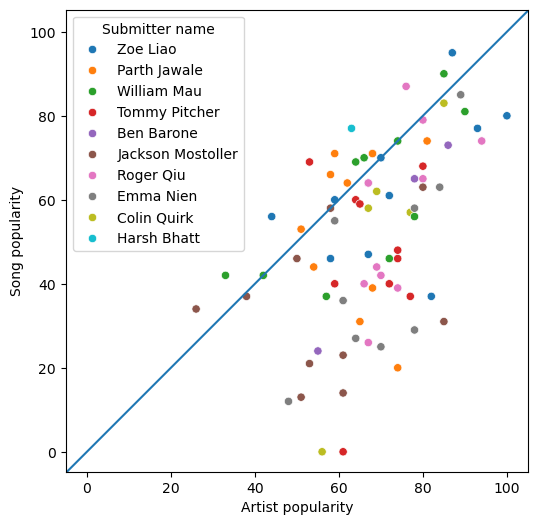

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.scatterplot(
    data=submissions,
    x="artist_popularity",
    y="song_popularity",
    hue="submitter_name",
    ax=ax,
)

ax.set_ylabel("Song popularity")
ax.set_xlabel("Artist popularity")
ax.legend(title="Submitter name")
ax.axline((0, 0), slope=1)
ax.axis("square")

### Popularity of submitted artists and songs
Next I wanted to characterize the popularity profiles of artists and songs based on submissions. Who submitted the least and most popular artists and songs? Below shows the distributions of artist and song popularities for each player's submissions, ranked by the average popularity across all rounds. Some insights:
- **Jackson** is the most indie submitter with the least rated popularity scores for both his songs and artists.
- **Zoe** is the most poppy submitter relatively high popularity scores for both songs and artists. 

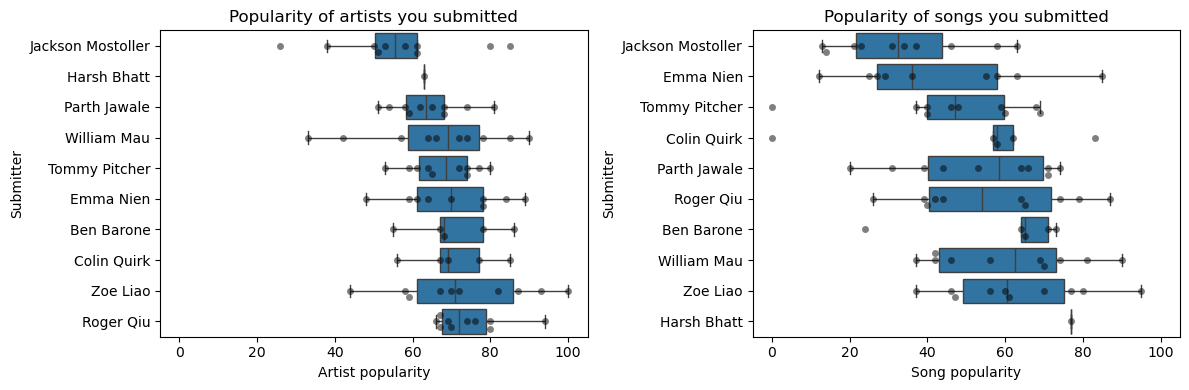

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

for ax, popularity_metric in zip(axs, ["artist_popularity", "song_popularity"]):
    # Get mean artist popularity for each submitter.
    popularity_by_submitter = (
        (submissions.groupby("submitter_name")[popularity_metric].mean().sort_values())
        .reset_index()
        .rename(
            columns={
                popularity_metric: f"submitted_{popularity_metric}",
                "submitter_name": "player",
            }
        )
    )

    plot_params = {
        "x": popularity_metric,
        "y": "submitter_name",
        "order": popularity_by_submitter["player"],
        "ax": ax,
    }

    sns.boxplot(
        **plot_params,
        data=submissions,
        showfliers=False,
    )
    sns.swarmplot(  # Plot individual data points from every round except Awesome Obscurity
        **plot_params,
        data=submissions,
        color="k",
        alpha=0.5,
    )

    ax.set_xlabel(popularity_metric.capitalize().replace("_", " "))
    ax.set_ylabel("Submitter")
    ax.set_title(f"Popularity of {popularity_metric.split("_")[0]}s you submitted")
fig.tight_layout()

### Popularity of artists you voted for
On the flip side, we can also look at the popularity of artists and songs you voted for. Though this data is constrained by the popularity of the voting options, and I'm not entirely sure what its utility is, it's still being shown here for completeness. 

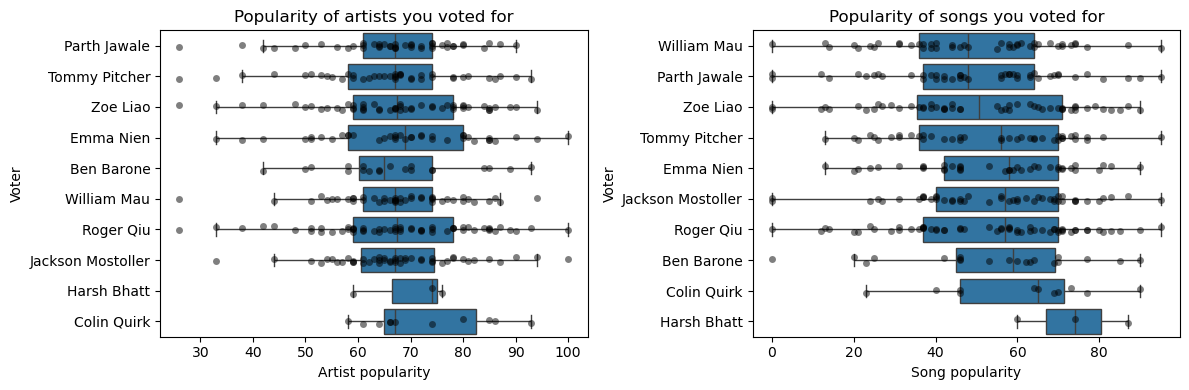

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for ax, popularity_metric in zip(axs, ["artist_popularity", "song_popularity"]):
    popularity_by_voter = (
        (
            results.query("vote_value > 0")
            .groupby("voter_name")
            .apply(lambda x: np.average(x[popularity_metric], weights=x["vote_value"]))
            .sort_values()
        )
        .reset_index()
        .rename(columns={0: f"voted_{popularity_metric}", "voter_name": "player"})
    )

    plot_params = {
        "data": results.query("vote_value > 0"),
        "x": popularity_metric,
        "y": "voter_name",
        "order": popularity_by_voter["player"],
        "ax": ax,
    }

    sns.boxplot(**plot_params, showfliers=False)
    sns.stripplot(
        **plot_params,
        color="k",
        alpha=0.5,
    )

    ax.set_xlabel(popularity_metric.capitalize().replace("_", " "))
    ax.set_ylabel("Voter")
    _ = ax.set_title(f"Popularity of {popularity_metric.split("_")[0]}s you voted for")

fig.tight_layout()

### Submitted artist popularity vs. final score
Is there a relationship between how well you do and how popular your submissions are? Shown below is the correlation between these two variables. There is a negative relationship where players with more popular submissions ended up with lower scores, but this relationship was not statistically significant (Spearman R=-0.34, p=0.249), so it does not look like the popularity of your submissions affect your standing. 

In [20]:
score_to_popularity = (
    final_score.sort_values("points", ascending=False)
    .reset_index()
    .rename(columns={"submitter_name": "player"})
    .merge(popularity_by_submitter, on="player", how="inner")
)
score_to_popularity = score_to_popularity.loc[
    score_to_popularity["player"] != "Jenni Podracky"
]

r, pvalue = scipy.stats.spearmanr(
    score_to_popularity["submitted_artist_popularity"], score_to_popularity["points"]
)

fig, ax = plt.subplots()

for i, row in score_to_popularity.iterrows():
    ax.annotate(row["player"], (row["submitted_artist_popularity"], row["points"]))
sns.regplot(
    data=score_to_popularity, x="submitted_artist_popularity", y="points", ax=ax
)
ax.set_title(f"Spearman R={round(r, 2)}, p={round(pvalue,3)}")
ax.set_xlabel("Average popularity of submitted artists")
_ = ax.set_ylabel("Final score")

KeyError: 'submitted_artist_popularity'

## Part III. Player relationships
Now we get to, in my opinion, the funnest insights -- the social network of voting patterns. By aggregating the total values of upvotes and downvotes for each pair of players, we can investigate the overall preferences of each player and identify similarities in preference profiles between everyone. This is a fancy way of saying: We can see who likes whose songs and who else has similar preferences. 

### Upvote clustering
Let's start with upvotes. Below is a heatmap of upvotes. The brightness of each square corresponds to the total upvote value that the voter (on the y-axis) gave the submitter (on the x-axis). 
- To see your "favorite" submitter, find your name on the right then move _across_ the matrix to find the brightest square. For example, **Will's** favorite submitter was **Jackie** and **Sean's** favorite submitter was **June** (more on this later).
- To see who your biggest fans were, find your name on the bottom then move _up_ the matrix to the find the brightest square.

On the left is a dendrogram created using [hierarchical clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering) which is a fancy method for identifying groups of similar items (in this case, player voting patterns). To read these dendrograms, think of them like evolutionary trees. Your closest "relative" is the one connected by the most immediate branch. For example, the dendrogram suggests that **Alex** and **Donna** have similar tastes (at least based on their voting patterns). Their next closest relative is **Chris** then **June**. **Will** has the most unique taste out of everyone because he is in his own clade (branch). 

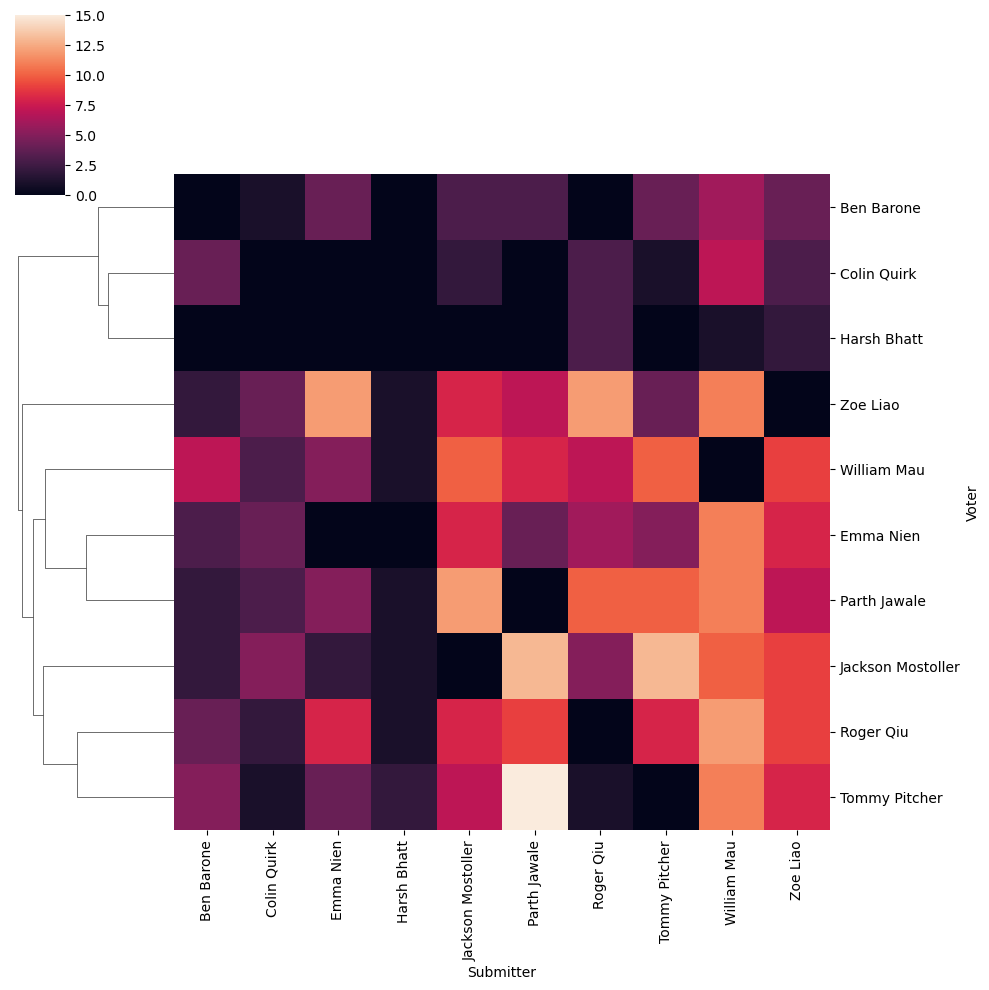

In [67]:
upvote_heatmap = pd.crosstab(
    upvotes["voter_name"],
    upvotes["submitter_name"],
    upvotes["vote_value"],
    aggfunc="sum",
).fillna(0)

c = sns.clustermap(data=upvote_heatmap, col_cluster=False)
ax = c.figure.axes[-2]
ax.set_xlabel("Submitter")
_ = ax.set_ylabel("Voter")

### Graphing player relationships
Next, we can adopt a [network science](https://en.wikipedia.org/wiki/Network_science) approach, which is pretty similar to the approach above but grants visualization techniques that might yield additional insights. Under this framework, each player is a _node_ that connect to each other through _edges_. Specifically, we will construct what's called [MultiDiGraph](https://networkx.org/documentation/stable/reference/classes/multidigraph.html) using the [networkx](https://networkx.org/documentation/stable/index.html) package. A MultiDiGraph is essential a Graph that has _Multiple_ edges and is _Directed_.
- Multiple edges because one edge type corresponds to upvotes and the other edge type corresponds to downvotes.
- Directed because the the edge has directionality -- an upvote is applied from voter to submitter, but not necessarily vice versa. 

In [36]:
G = nx.from_pandas_edgelist(
    edgelist,
    "voter_name_pretty",
    "submitter_name_pretty",
    edge_attr="vote_value",
    create_using=nx.MultiDiGraph,
    edge_key="vote_sign",
)

### Plot whole graph
We'll begin this approach by visualizing the whole graph below. It's pretty overwhelming so let's break it down. 

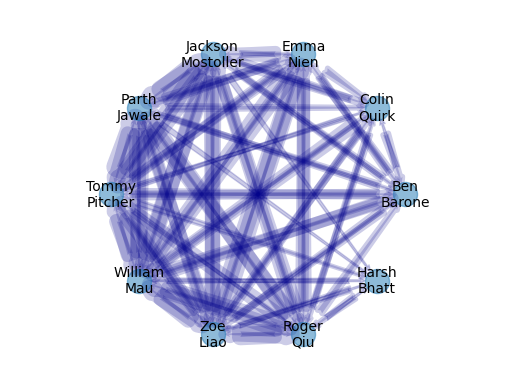

In [37]:
pos = nx.circular_layout(G)
edges = G.edges(data="vote_value", keys=True)
edge_label_bbox = {"alpha": 0, "pad": 0}
edge_params = {
    "G": G,
    "pos": pos,
    "min_source_margin": 20,
    "min_target_margin": 0,
    "alpha": 0.2,
    "arrowstyle": "fancy",
}
edge_colors = {"upvote": "darkblue", "downvote": "darkred"}
edge_label_params = {"G": G, "pos": pos, "bbox": edge_label_bbox}
edge_label_positions = {"upvote": 0.5, "downvote": 0.75}

fig, ax = plt.subplots()

nx.draw_networkx_nodes(G, pos=pos, ax=ax, alpha=0.5, margins=0.1)
nx.draw_networkx_labels(G, pos=pos, font_size=10, ax=ax)

for vote_type, color in edge_colors.items():
    _ = nx.draw_networkx_edges(
        **edge_params,
        edgelist=[(i, j) for i, j, key in G.edges(keys=True) if key == vote_type],
        width=[value for i, j, key, value in edges if key == vote_type],
        ax=ax,
        edge_color=color,
    )

ax.axis("equal")
_ = ax.axis("off")

### Who do I vote for?
Instead of plotting the entire graph, let's focus on one player at a time and plot their "outgoing" edges (i.e., their votes). Each subplot below shows those outgoing edges. You can find yours and study how you tended to vote, whether you tended to upvote or downvote specific individuals' submissions, or whether it was evenly distributed.

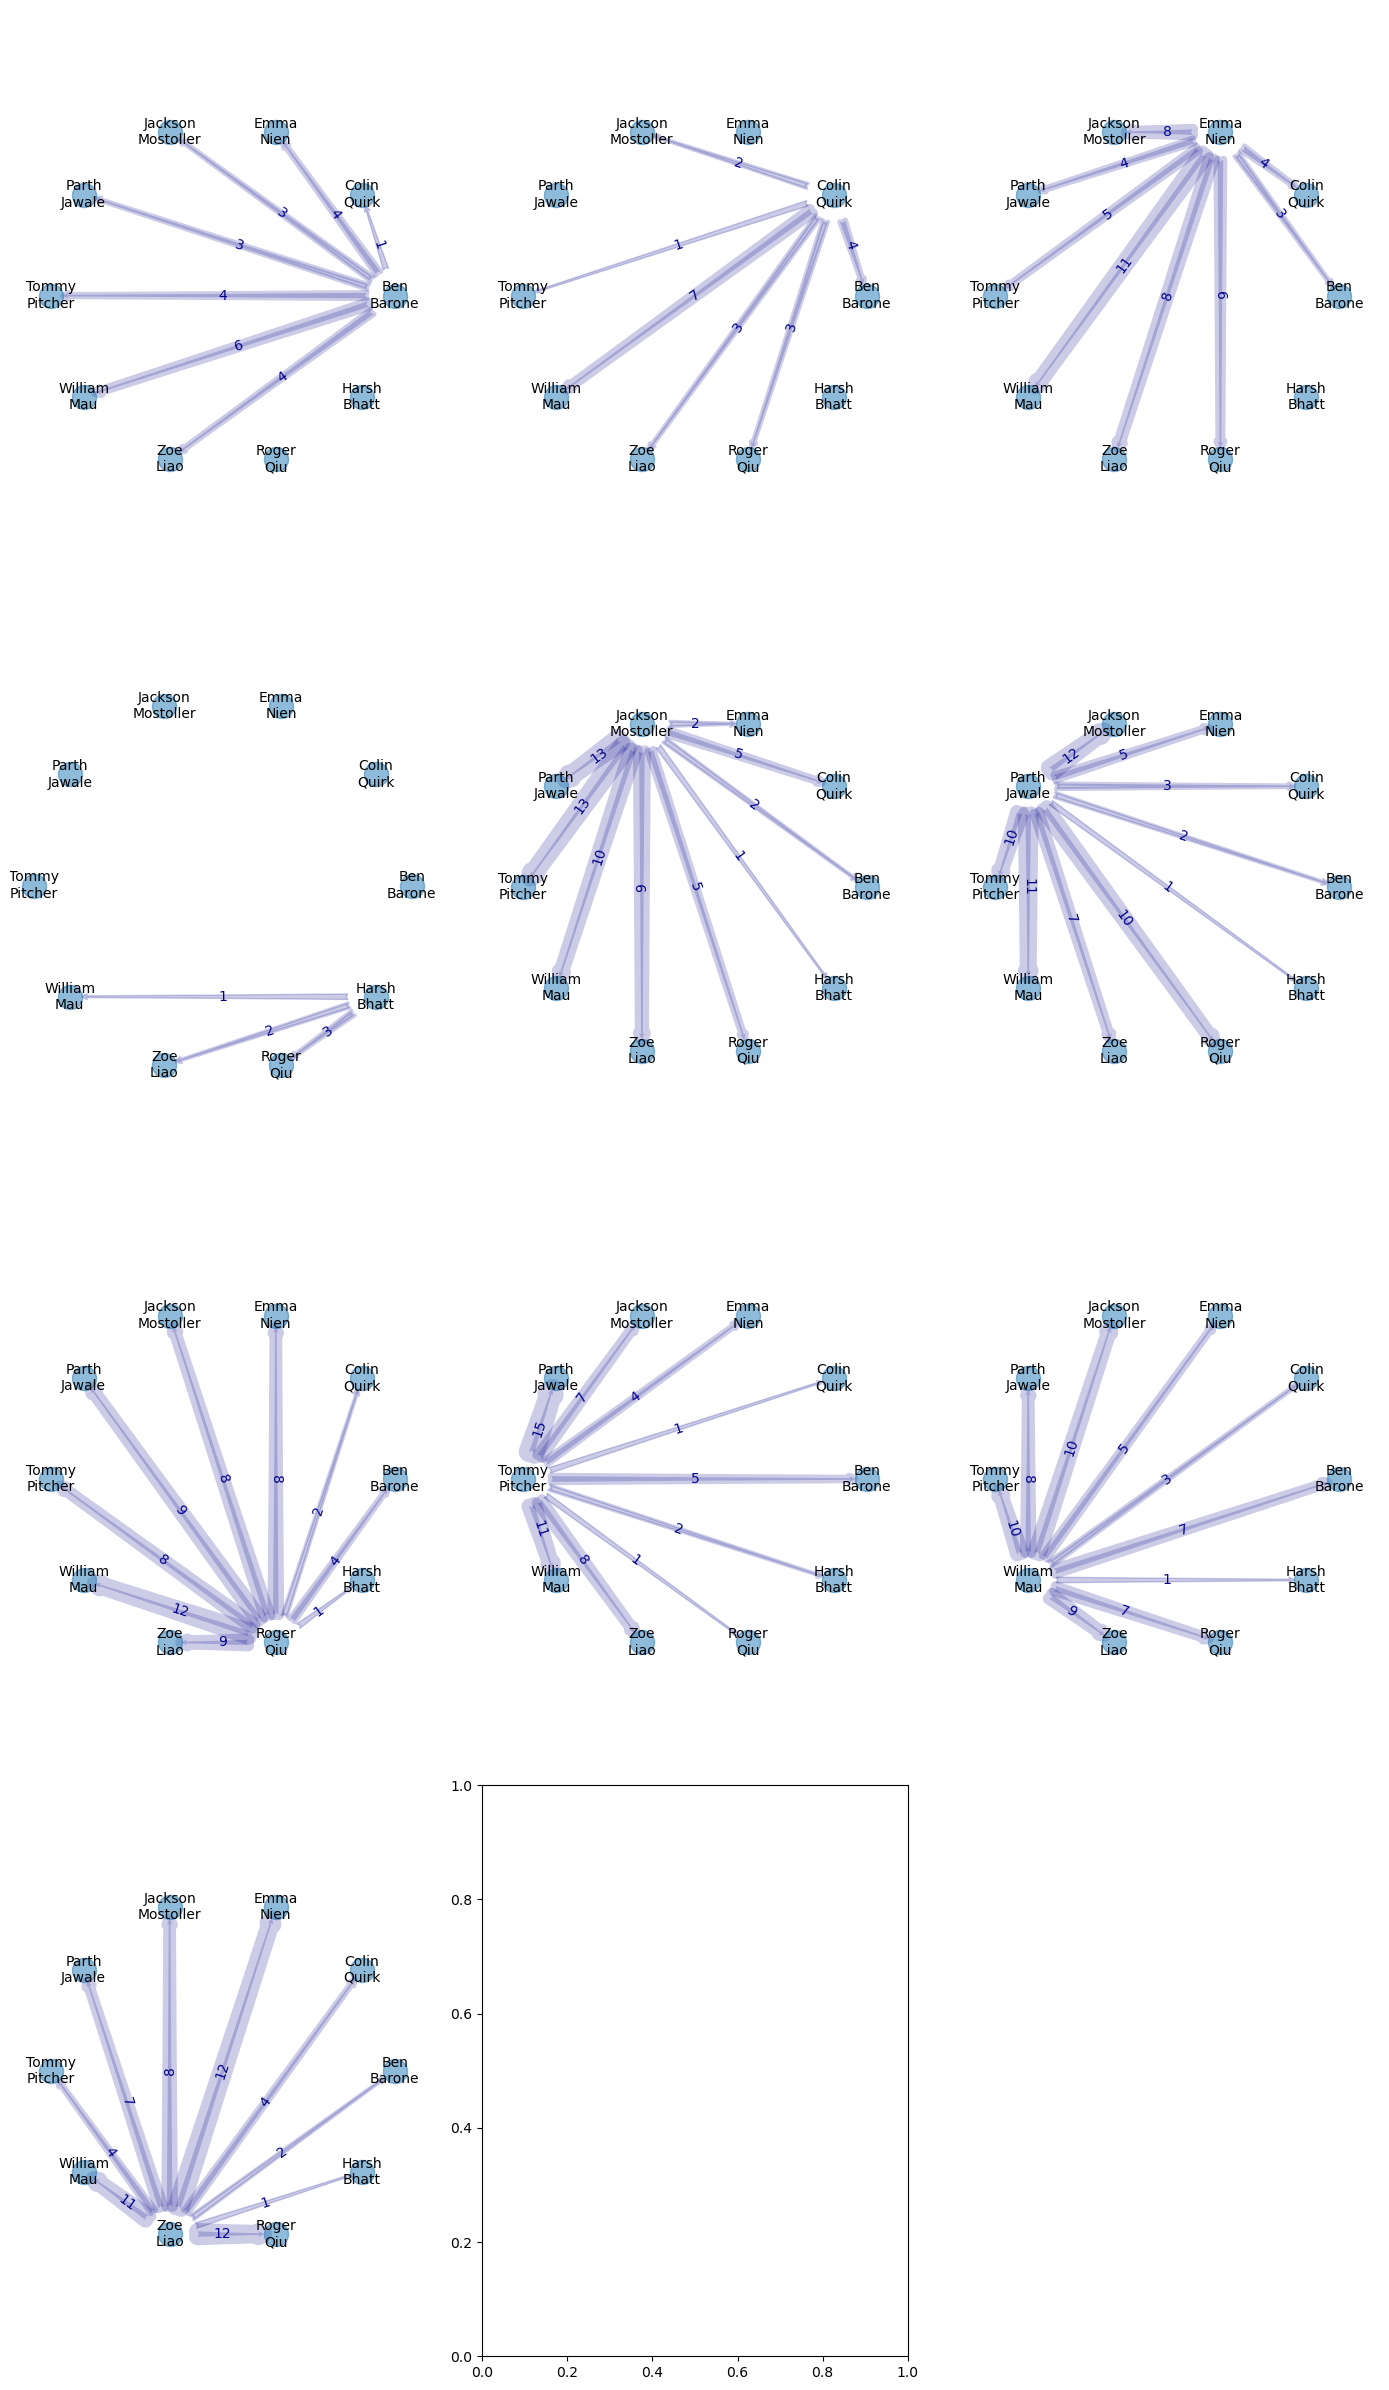

In [39]:
fig, axs = plt.subplots(4, 3, figsize=(14, 24))

for voter, ax in zip(edgelist["voter_name_pretty"].unique(), axs.flat):
    nx.draw_networkx_nodes(G, pos=pos, ax=ax, alpha=0.5, margins=0.1)
    nx.draw_networkx_labels(G, pos=pos, font_size=10, ax=ax)

    for vote_type, color in edge_colors.items():
        _ = nx.draw_networkx_edges(
            **edge_params,
            edgelist=[
                (i, j) for i, j, key, value in edges if key == vote_type and i == voter
            ],
            width=[
                value for i, j, key, value in edges if key == vote_type and i == voter
            ],
            edge_color=color,
            ax=ax,
        )

    for vote_type, color in edge_colors.items():
        _ = nx.draw_networkx_edge_labels(
            **edge_label_params,
            edge_labels={
                (i, j): value
                for i, j, key, value in edges
                if i == voter and key == vote_type
            },
            label_pos=edge_label_positions[vote_type],
            font_color=color,
            ax=ax,
        )

    ax.axis("equal")
    ax.axis("off")
axs.flat[-1].axis("off")
fig.tight_layout()

### Who votes for me?
Conversely, we can also examine _incoming_ edges (i.e., who votes for you). There are a number of insights here that are more apparent than in the previous visualization:
- In a previous analysis, we found that **Chris's** submissions were the most unpopular, but here we get the additional insight that his submissions are pretty much universally disliked by most players. Only 4 out of 13 players never downvoted you.
- **Donna** in particular absolutely abhors **Chris's** submissions, as demonstrated by her -5 downvotes and 0 upvotes for him.
- The women in couples (**Jackie**, **June**, and **Donna**) whose partners are also in the league had the highest number of upvotes from those partners. **Will** gave **Jackie** 12 upvotes, **Sean** gave **June** 11 upvotes, and **Richard** gave **Donna** 8 upvotes.
- However, this "collusion" was not reciprocated. **Jackie** only gave **Will** 5 upvotes (vs. 12), **June** gave **Sean** 8 upvotes (vs. 11), and **Donna** gave **Richard** 4 upvotes (vs. 8). Therefore, the men are simps. 

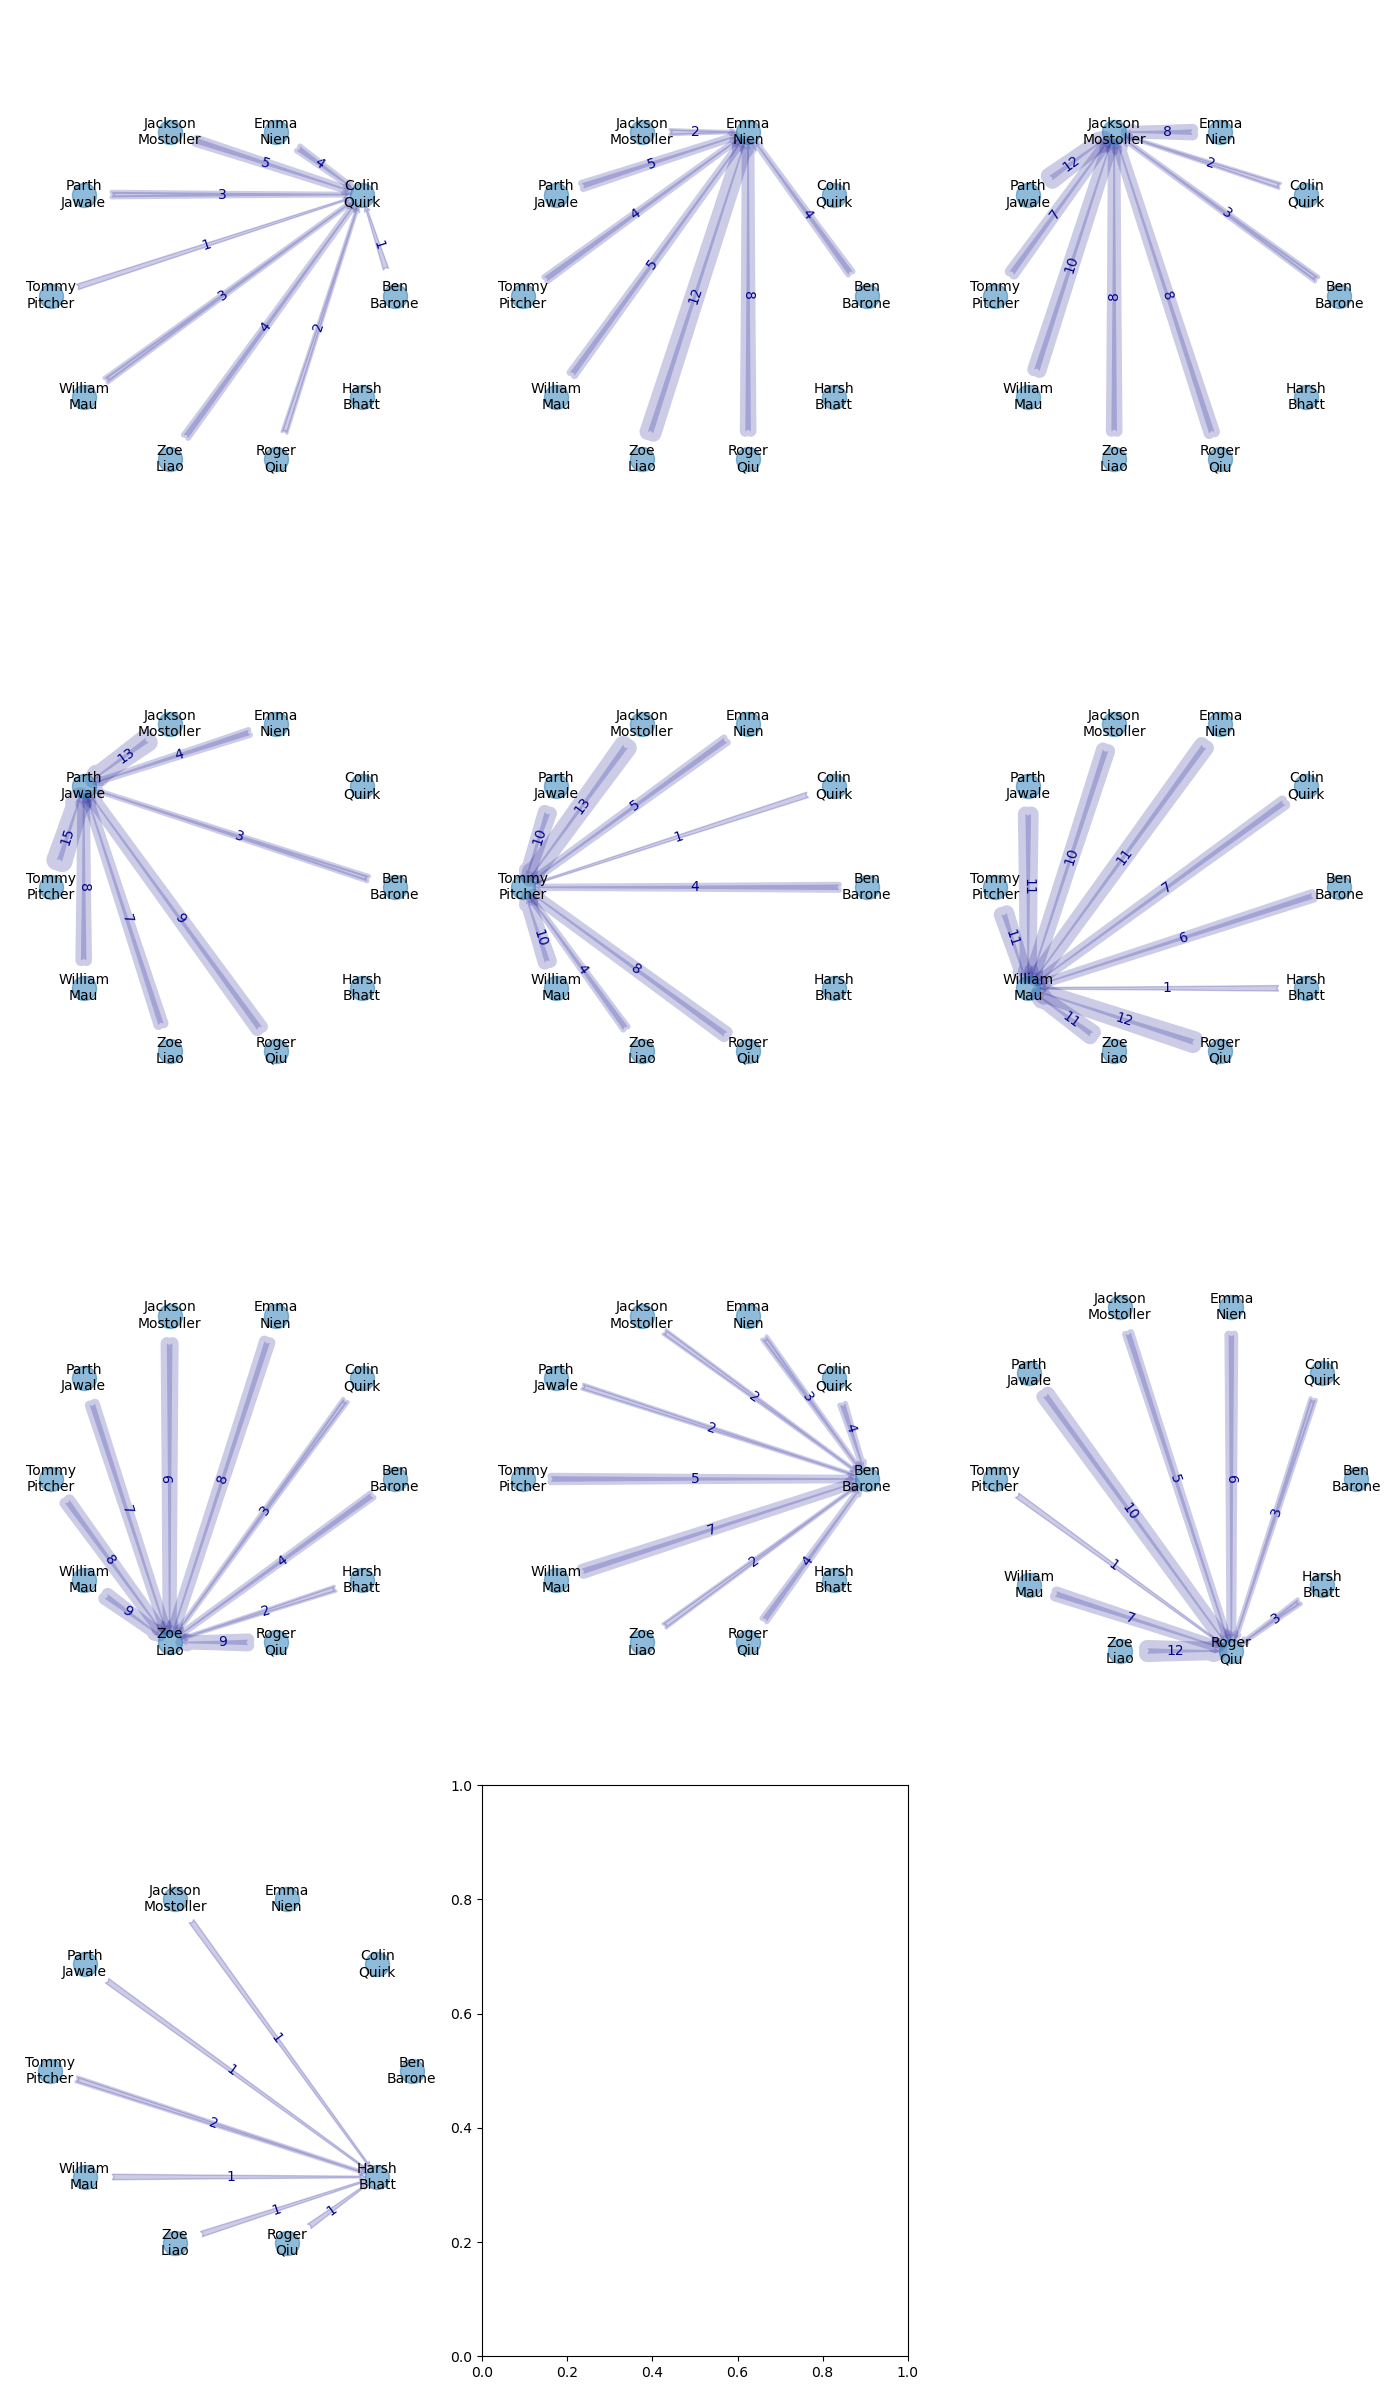

In [40]:
fig, axs = plt.subplots(4, 3, figsize=(14, 24))

for submitter, ax in zip(edgelist["submitter_name_pretty"].unique(), axs.flat):
    nx.draw_networkx_nodes(G, pos=pos, ax=ax, alpha=0.5, margins=0.1)
    nx.draw_networkx_labels(G, pos=pos, font_size=10, ax=ax)

    for vote_type, color in edge_colors.items():
        _ = nx.draw_networkx_edges(
            **edge_params,
            edgelist=[
                (i, j)
                for i, j, key, value in edges
                if key == vote_type and j == submitter
            ],
            width=[
                value
                for i, j, key, value in edges
                if key == vote_type and j == submitter
            ],
            edge_color=color,
            ax=ax,
        )

    for vote_type, color in edge_colors.items():
        _ = nx.draw_networkx_edge_labels(
            **edge_label_params,
            edge_labels={
                (i, j): value
                for i, j, key, value in edges
                if j == submitter and key == vote_type
            },
            label_pos=edge_label_positions[vote_type],
            font_color=color,
            ax=ax,
        )

    ax.axis("equal")
    ax.axis("off")
axs.flat[-1].axis("off")
fig.tight_layout()

### Colluding couples?
As mentioned above, it appears as though couples vote for their partners more often than they vote for other people. Is this a coincidence or a real effect? I tested this statistically by grouping the vote values for couples and non-couples. There was indeed a significant statistical difference between couples and non-couples (Mann-Whitney U test p<0.0005). There are a few possible explanations for this finding:
1. Couples are colluding and voting for each other (albeit unidirectionally so the men get less benefit).
2. Similar music tastes attracted them together in the first place (the opposite causality direction).
3. The [mere exposure effect](https://en.wikipedia.org/wiki/Mere-exposure_effect) from having heard a submitted song in passing (or often) in their communal spaces increased their positive attitude towards those songs.

Either way, lols

In [25]:
temp = [
    ("Jackie Wu", "Will Mau"),
    ("Donna Koo", "Richard Hill"),
    ("June Wang", "Sean Wong"),
]
couples = temp.copy()
for f, m in temp:
    couples.append((m, f))
couples_df = pd.DataFrame(couples, columns=["voter_name", "submitter_name"])
couples_df["couple_status"] = "couple"

couple_edges = edgelist.merge(
    couples_df, on=["voter_name", "submitter_name"], how="left"
).fillna("non-couple")

couple_edges = (
    couple_edges.groupby(["voter_name", "submitter_name", "couple_status"])[
        "vote_value"
    ]
    .sum()
    .reset_index()
)

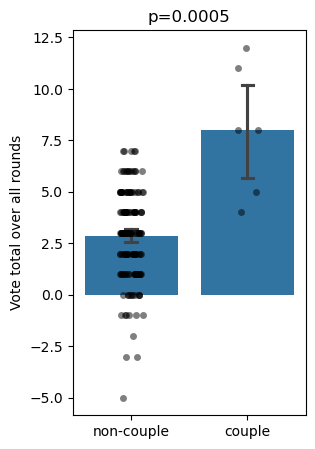

In [30]:
pvalue = scipy.stats.mannwhitneyu(
    couple_edges.query("couple_status == 'couple'")["vote_value"],
    couple_edges.query("couple_status == 'non-couple'")["vote_value"],
).pvalue

fig, ax = plt.subplots(figsize=(3, 5))

sns.barplot(data=couple_edges, x="couple_status", y="vote_value", capsize=0.1, ax=ax)
sns.stripplot(
    data=couple_edges, x="couple_status", y="vote_value", color="k", alpha=0.5, ax=ax
)
ax.set_xlabel("")
ax.set_ylabel("Vote total over all rounds")
_ = ax.set_title(f"p={round(pvalue,4)}")

# Appendix
Below are random other things that I looked at but didn't include in the main body. 

## Common genres

In [27]:
submissions.groupby(["submitter_name", "primary_genre"])[
    "round_number"
].count().reset_index().rename(columns={"round_number": "count"}).sort_values(
    ["submitter_name", "count"], ascending=False
).groupby(
    "submitter_name"
).first().sort_values(
    "count", ascending=False
)

,primary_genre,count
submitter_name,,
Michelle Wang,'pop',4
Tammy Liaw,'dance pop',3
Alex Chao,'pop',2
Alex Mui,'art pop',2
Chris Podracky,'alternative metal',2
Donna Koo,'c-pop',2
Jackie Wu,'k-pop',2
Jen Tsang,'dance pop',2
June Wang,'neo soul',2


### Popularity of submitted vs. voted artists
The plot below shows the relationship between your voting preferences and your submitting preferences with respect to artist popularity. Players below the dotted line tend to vote for less popular artists than they submit and players above the line vice versa. 

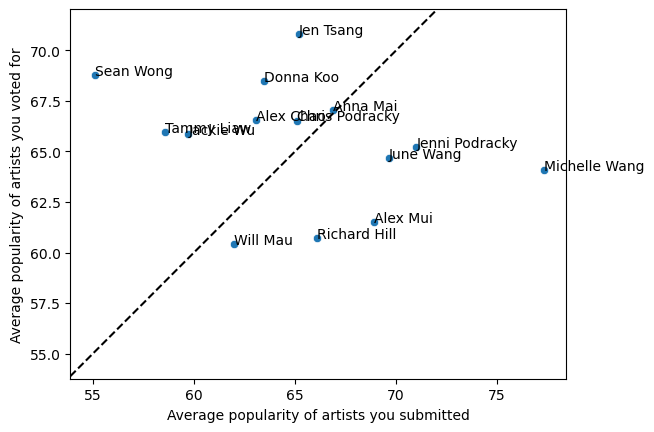

In [42]:
popularity_corr = popularity_by_voter.merge(
    popularity_by_submitter, how="inner", on="player"
)

fig, ax = plt.subplots()
sns.scatterplot(
    data=popularity_corr,
    x="submitted_artist_popularity",
    y="voted_artist_popularity",
    ax=ax,
)
for _, row in popularity_corr.iterrows():
    ax.annotate(
        row["player"],
        (row["submitted_artist_popularity"], row["voted_artist_popularity"]),
    )

ax.axline((55, 55), slope=1, linestyle="--", color="k")
ax.set_xlabel("Average popularity of artists you submitted")
ax.set_ylabel("Average popularity of artists you voted for")
_ = ax.axis("equal")